# Modelling Solar generation across Multiple Sites

This example shows how `timeserio` helps building deep learning models for time series forecasting. Especially,
we deal with the case of many related timeseries.

We demonstrate some core functionality and concepts, without striving for model accuracy or seeking out additional features like historic weather forecasts.

We will be using the dataset on solar (photo-voltaic, PV) generation potential across Europe, as collected by [SETIS](https://setis.ec.europa.eu/EMHIRES-datasets). The dataset presents solar generation, normalized to the solar capacity installed as of 2015.

## To get data from the source (temporary)

### Download the data

In [1]:
!mkdir -p ~/tmp/datasets; cd ~/tmp/datasets; wget https://setis.ec.europa.eu/sites/default/files/EMHIRES_DATA/Solar/EMHIRESPV_country_level.zip; unzip -o EMHIRESPV_country_level.zip; rm EMHIRESPV_country_level.zip

--2020-03-23 06:12:59--  https://setis.ec.europa.eu/sites/default/files/EMHIRES_DATA/Solar/EMHIRESPV_country_level.zip
Resolving setis.ec.europa.eu (setis.ec.europa.eu)... 139.191.207.52
Connecting to setis.ec.europa.eu (setis.ec.europa.eu)|139.191.207.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93401258 (89M) [application/zip]
Saving to: ‘EMHIRESPV_country_level.zip’

EMHIRESPV_country_l 100%[===================>]  89.07M  9.95MB/s    in 13s     

2020-03-23 06:13:14 (6.97 MB/s) - ‘EMHIRESPV_country_level.zip’ saved [93401258/93401258]

Archive:  EMHIRESPV_country_level.zip
  inflating: EMHIRESPV_TSh_CF_Country_19862015.xlsx  


### Download data and save in a more performant format

In [0]:
import pandas as pd
import numpy as np

In [3]:
%%time
df = pd.read_excel("~/tmp/datasets/EMHIRESPV_TSh_CF_Country_19862015.xlsx")

CPU times: user 1min 21s, sys: 649 ms, total: 1min 22s
Wall time: 1min 22s


In [4]:
df.head(3)

,Time_step,Date,Year,Month,Day,Hour,AL,AT,BA,BE,BG,CH,CY,CZ,DE,DK,EE,ES,FI,FR,EL,HR,HU,IE,IT,LT,LU,LV,ME,MK,NL,NO,PL,PT,RO,RS,SI,SK,SE,XK,UK
0,1,1986-01-01 00:00:00,1986,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1986-01-01 01:00:00,1986,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1986-01-01 02:00:00,1986,1,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Reshape data to tall format
We add a `country` column to identify each table row.

In [0]:
id_vars = ['Time_step', 'Date', 'Year', 'Month', 'Day', 'Hour']
country_vars = list(set(df.columns) - set(id_vars))
df_tall = pd.melt(df, id_vars=id_vars, value_vars=country_vars, var_name="country", value_name="generation")

### Load the data from parquet

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
%%time
df = df_tall

CPU times: user 20 µs, sys: 0 ns, total: 20 µs
Wall time: 23.8 µs


## Split into train-test sets

In [8]:
df_dev = df.iloc[:100]
df_train, df_test = df[df['Year'] < 2015], df[df['Year'] >= 2015]
len(df_train), len(df_test)

(8897280, 306600)

In [9]:
df.groupby("Year").count().reset_index()

,Year,Time_step,Date,Month,Day,Hour,country,generation
0,1986,306600,306600,306600,306600,306600,306600,306600
1,1987,306600,306600,306600,306600,306600,306600,306600
2,1988,307440,307440,307440,307440,307440,307440,307440
3,1989,306600,306600,306600,306600,306600,306600,306600
4,1990,306600,306600,306600,306600,306600,306600,306600
5,1991,306600,306600,306600,306600,306600,306600,306600
6,1992,307440,307440,307440,307440,307440,307440,307440
7,1993,306600,306600,306600,306600,306600,306600,306600
8,1994,306600,306600,306600,306600,306600,306600,306600
9,1995,306600,306600,306600,306600,306600,306600,306600


In [10]:
%%time
df_test.to_parquet("/content/test.parquet")

CPU times: user 104 ms, sys: 14 ms, total: 118 ms
Wall time: 130 ms


In [11]:
!ls /content -l

total 3784
drwxr-xr-x 1 root root    4096 Mar 18 16:23 sample_data
-rw-r--r-- 1 root root 3868781 Mar 23 06:14 test.parquet


In [12]:
from google.colab import files
files.download("/content/test.parquet")

MessageError: ignored

## Auto-regressive model

In an auto-regressive model, we treat past values of the timeseries as input features to the forecasting model.
While the functional form of the model is important, deep learning frameworks give us an easy way to try different approaches including CNNs, RNNs, etc.

A key part remains however - we must be able to supply abundant training examples, each consisting of a window of consecutive values, the target, and (optinally) the time between the end of the window and the target (the "forecast horizon"). A long timeseries can be used to generate many examples simply by sampling the windows randomly from the original timeseries - in fact, for a realistic timeseries, pre-generating training examples in memory is prohibitively expensive. `timeserio` provides a way to generate sequence training examples on-demand from data held in memory, or even from datasets partitioned into multiple files.


In [Model 1], we have explored the SETIS PV generation dataset and built a powerful and performant model using 
`timeserio`'s `MultiModel` and datetime feature generation pipelines. In this part, we instead train an auto-regressive model using more advanced batch generator features.

Remember the metrics our previous model achieved on the train/test split (without any parameter tuning):

|&nbsp;| train | test |
|---|---|---|
| MSE | 0.0063 | 0.0068 |
| MAE | 0.0401 | 0.0424 |

In this notebook, we will build a simple model to create short-range predictions (between 1 and 2 hours ahead) based on recent history (say 6h)

In [13]:
!pip install timeserio

In [14]:
from timeserio.batches.chunked.pandas import SequenceForecastBatchGenerator

batchgen_train = SequenceForecastBatchGenerator(
    df=df_train, batch_size=2**15,
    sequence_length=6,
    sequence_columns=["generation", "Time_step"],
    last_step_columns=["Time_step"],
    forecast_steps_min=1,
    forecast_steps_max=2,
    batch_offset=True,
    id_column="country",
    batch_aggregator=1
)

Using TensorFlow backend.


In [15]:
len(batchgen_train)

70

In [16]:
%%time
batch = batchgen_train[0]

CPU times: user 517 ms, sys: 2.1 ms, total: 519 ms
Wall time: 515 ms


In [17]:
batch.head(2)

country generation Time_step seq_generation  ... seq_Time_step         end_of_Time_step
                                            0  ...             3   4   5                 
0      HR   0.014195         8       0.000000  ...             5   6   7                7
1      HR   0.093692        14       0.014195  ...            11  12  13               13

[2 rows x 16 columns]

In [18]:
%%time
batch = batchgen_train[-1]

CPU times: user 504 ms, sys: 27 ms, total: 531 ms
Wall time: 528 ms


In [19]:
batch.head(2)

country generation Time_step  ... seq_Time_step         end_of_Time_step
                                ...             4       5                 
0      PT   0.809717    196620  ...        196617  196618           196618
1      PT   0.341062    196626  ...        196623  196624           196624

[2 rows x 16 columns]

### Sequence and Forecast horizon features

In [0]:
from timeserio.pipeline import Pipeline
from timeserio.preprocessing import PandasColumnSelector, PandasValueSelector

class ColumnDifferenceValues:
    """Compute difference feature of two columns"""
    def __init__(self, *, col_plus, col_minus):
        self.col_plus = col_plus
        self.col_minus = col_minus
    
    def fit(self, *args, **kwargs):
        return self
    
    def fit_transform(self, df, *args, **kwargs):
        return self.transform(df, *args, **kwargs)

    def transform(self, df, *args, **kwargs):
        return (df[self.col_plus] - df[self.col_minus]).values.reshape(-1, 1)

    
seq_pipeline = PandasValueSelector("seq_generation")
fc_horizon_pipeline = ColumnDifferenceValues(col_plus="Time_step", col_minus="end_of_Time_step")
target_pipeline = PandasValueSelector("generation")

### Define the Neural Network Architecture

We define a regression network with two inputs: sequence of previous readings, and the forecast horizon

In [0]:
from timeserio.keras.multinetwork import MultiNetworkBase

from keras.layers import Input, Dense, Flatten, Concatenate, Reshape, Permute, Conv1D, BatchNormalization, MaxPool1D, Activation
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class ARForecastingNetwork(MultiNetworkBase):
    def _model(
        self,
        *,
        seq_length=6,  # number of real-valued features
        filters=(1, ),
        kernel_sizes=(1, ),
        strides=(1, ),
        pools=(1, ),
        hidden_units=(8, 8),
        lr=0.01
    ):
        horizon_input = Input(shape=(1,), name='horizon')
        seq_input = Input(shape=(seq_length,), name='sequence')
        encoding = Reshape(
            target_shape=(-1, 1)
        )(seq_input)
                
        for idx, (_filters, _kernel_size, _strides, _pool) in enumerate(zip(filters, kernel_sizes, strides, pools)):
            encoding = Conv1D(filters=_filters, kernel_size=_kernel_size, strides=_strides, padding="same", name=f"conv_{idx}")(encoding)
            encoding = BatchNormalization()(encoding)
            encoding = Activation(activation='relu')(encoding)
            encoding = MaxPool1D(pool_size=_pool)(encoding)
        encoding = Flatten()(encoding)

        output = Concatenate(name='concatenate')([encoding, horizon_input])
        for idx, _hidden_units in enumerate(hidden_units):
            output = Dense(_hidden_units, activation='relu', name=f'dense_{idx}')(output)
        output = Dense(1, name='generation', activation='relu')(output)
        
        encoding_model = Model(seq_input, encoding)
        forecasting_model = Model([seq_input, horizon_input], output)
        
        optimizer = Adam(lr=lr)
        forecasting_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
        
        return {'encoder': encoding_model, 'forecast': forecasting_model}

    
multinetwork = ARForecastingNetwork(seq_length=6, lr=0.001)

In [0]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

def vis_model(model, show_shapes=False, show_layer_names=True, rankdir='TB'):
    """Visualize model in a notebook."""
    return SVG(
        model_to_dot(
            model, show_shapes=show_shapes, show_layer_names=show_layer_names, rankdir=rankdir
        ).create(prog='dot', format='svg')
    )

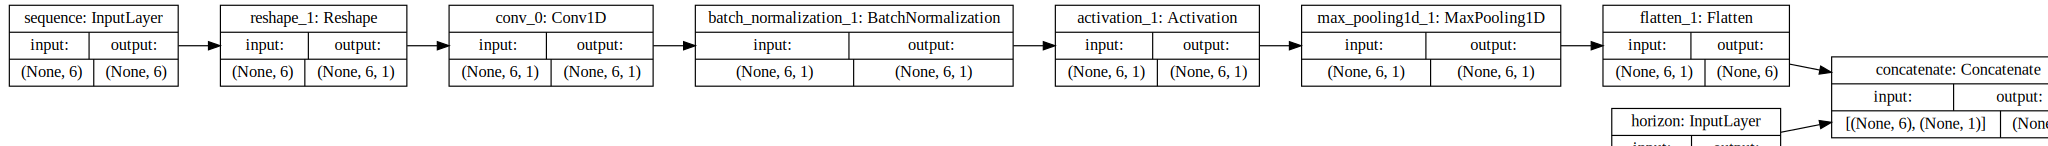

In [23]:
vis_model(multinetwork.model["forecast"], show_shapes=True, rankdir="LR")

### Connect feature pipelines to the neural network

In [0]:
from timeserio.pipeline import MultiPipeline

In [0]:
multipipeline = MultiPipeline({
    "sequence": seq_pipeline,
    "horizon": fc_horizon_pipeline,
    "target": target_pipeline
})

In [0]:
from timeserio.multimodel import MultiModel

manifold = {
    # keras_model_name: (input_pipes, output_pipes)
    "encoder": ("sequence", None),
    "forecast": (["sequence", "horizon"], "target")
}

multimodel = MultiModel(
    multinetwork=multinetwork,
    multipipeline=multipipeline,
    manifold=manifold
)

### Fit model from the batch generator

`multimodel.fit_generator()` will apply pipelines correctly to the training batch generator, and, if `validation_data` is provided in the form of another (pandas) batch generator,
evaluate the relevant metrics. In addition, feature extraction for each batch will benefit from the `workers` parallelism.

In [27]:
!pip install kerashistoryplot

In [28]:
from kerashistoryplot.callbacks import PlotHistory
#plot_callback = PlotHistory(figsize=(15, 3), n_cols=3, batches=False)

multimodel.fit_generator(
    batchgen_train, model="forecast", verbose=1, epochs=10,
    reset_weights=True,
    workers=4
    #, callbacks=[plot_callback]
)



Epoch 1/10
70/70 [==============================] - 40s 566ms/step - loss: 0.0441 - mean_absolute_error: 0.1659
Epoch 2/10
70/70 [==============================] - 36s 515ms/step - loss: 0.0289 - mean_absolute_error: 0.1222
Epoch 3/10
70/70 [==============================] - 38s 546ms/step - loss: 0.0221 - mean_absolute_error: 0.0974
Epoch 4/10
70/70 [==============================] - 38s 544ms/step - loss: 0.0190 - mean_absolute_error: 0.0888
Epoch 5/10
70/70 [==============================] - 38s 543ms/step - loss: 0.0163 - mean_absolute_error: 0.0790
Epoch 6/10
70/70 [==============================] - 38s 544ms/step - loss: 0.0161 - mean_absolute_error: 0.0768
Epoch 7/10
70/70 [==============================] - 38s 545ms/step - loss: 0.0159 - mean_absolute_error: 0.0743
Epoch 8/10
70/70 [==============================] - 38s 542ms/step - loss: 0.0148 - mean_absolute_error: 0.0721
Epoch 9/10
70/70 [==============================] - 39s 563ms/step - loss: 0.0146 - mean_absolute_erro

persist the model:

In [0]:
model_file="/tmp/model.pickle"
network_file="/tmp/network.pickle"
weights_file="/tmp/weights.pickle"

In [0]:
from timeserio.utils.pickle import loadf, dumpf
dumpf(multimodel, model_file)
dumpf(multinetwork, network_file)
dumpf(multinetwork.weights, weights_file)

In [31]:
from google.colab import files
files.download(model_file)
files.download(network_file)
files.download(weights_file)

MessageError: ignored

In [32]:
multimodel.multinetwork.weights

{'encoder': [array([[[-0.19326153]]], dtype=float32),
  array([-0.01388481], dtype=float32),
  array([1.001507], dtype=float32),
  array([0.1724715], dtype=float32),
  array([-0.04395088], dtype=float32),
  array([0.00157916], dtype=float32)],
 'forecast': [array([[[-0.19326153]]], dtype=float32),
  array([-0.01388481], dtype=float32),
  array([1.001507], dtype=float32),
  array([0.1724715], dtype=float32),
  array([-0.04395088], dtype=float32),
  array([0.00157916], dtype=float32),
  array([[ 0.43342778,  0.37757066,  0.6303462 ,  0.71829   ,  0.29318696,
          -0.4383042 , -0.42728963,  0.54490477],
         [-0.0376397 ,  0.5487245 ,  0.5358355 ,  0.43267414,  0.23670724,
           0.4768411 , -0.29845628, -0.06619695],
         [ 0.25497553,  0.13796303, -0.42512372,  0.46833453,  0.57893   ,
           0.25583443,  0.5749272 ,  0.18844144],
         [-0.6698033 , -0.05163093, -0.26994517, -0.4319419 ,  0.34235328,
          -0.54363394, -0.21543871, -0.13967685],
         [-0

### Evaluate performance on test data
We can evaluate the model on the validation data generator, which can also be out-of-memory:

In [0]:
batchgen_test = SequenceForecastBatchGenerator(
    df=df_test, batch_size=2**15,
    sequence_length=6,
    sequence_columns=["generation", "Time_step"],
    last_step_columns=["Time_step"],
    forecast_steps_min=1,
    forecast_steps_max=2,
    batch_offset=False,
    id_column="country",
    batch_aggregator=1
)

In [34]:
multimodel.evaluate_generator(batchgen_test, model="forecast", verbose=1)

35/35 [==============================] - 2s 43ms/step


[0.01902832679583558, 0.08507909572550229]

While the model takes longer to train (and longer still with practical encoder architectures), it can be tuned to achieve higher performanec, especially if encodings are combined with datetime features.

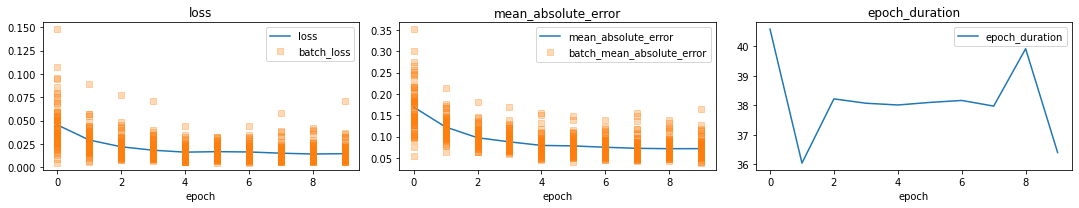

In [35]:
from kerashistoryplot.plot import plot_history
history = multimodel.history[-1]["history"]
plot_history(history, figsize=(15, 3), n_cols=3);